100%|██████████| 546/546 [20:24<00:00,  2.24s/it]  


✅ Best Config → Sigma: 50.0, Threshold: 10000.0, Accuracy: 1.0000


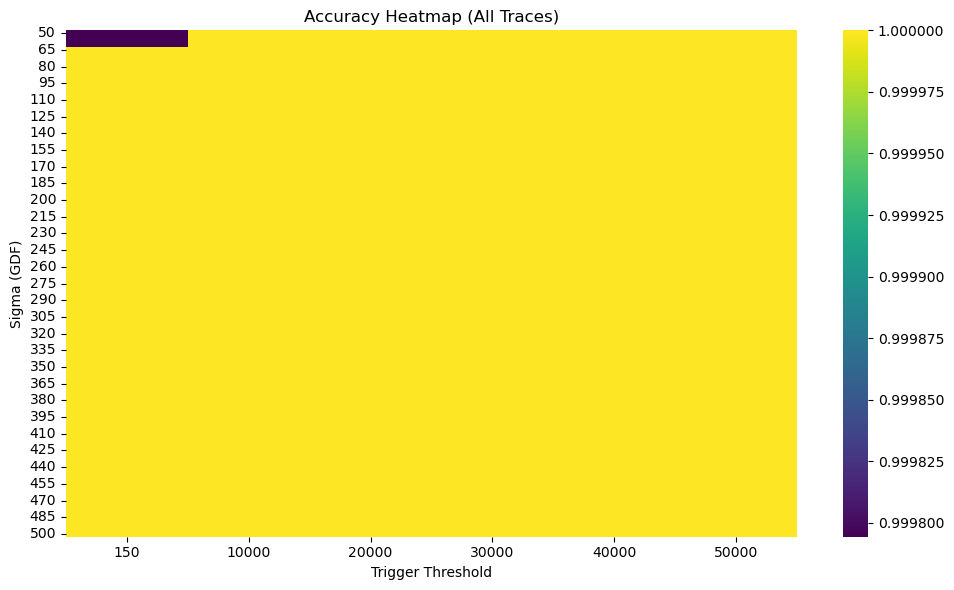

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import scipy.stats
from tqdm import tqdm
import multiprocessing as mp

# Load all traces
ka_data_1 = np.load('Ka_traces_1.npz')['data']
ka_data_2 = np.load('Ka_traces_2.npz')['data']
kb_data = np.load('Kb_traces.npz')['data']
traces = np.concatenate([ka_data_1, ka_data_2, kb_data], axis=0)

def get_gdf_kernel(sigma, n_sigma=3):
    x = np.arange(-sigma * n_sigma, sigma * n_sigma + 1)
    gaus = scipy.stats.norm(scale=sigma).pdf(x)
    kernel = np.diff(gaus)
    step_function = -np.heaviside(x[:-1], 1)
    return kernel / np.dot(kernel, step_function)

def threshold_trigger_2d(records, sigma, trigger_threshold=100, deactivation_threshold_coefficient=1, trigger_holdoff=0, n_sigma=3):
    kernel = get_gdf_kernel(sigma, n_sigma)
    num_records = len(records)
    TP, TN, FP = 0, 0, 0

    kernel_len = len(kernel)
    conv_len = records.shape[1] - kernel_len + 1

    for raw in records:
        filtered = signal.convolve(raw, kernel, mode='valid')
        deactivate_threshold = trigger_threshold * deactivation_threshold_coefficient
        hits = []
        triggered = False
        j = 0
        while j < conv_len:
            if not triggered and filtered[j] > trigger_threshold:
                hits.append(j)
                triggered = True
                j += trigger_holdoff
            elif triggered and filtered[j] < deactivate_threshold:
                triggered = False
            j += 1

        if len(hits) == 1:
            TP += 1
        elif len(hits) == 0:
            TN += 1
        elif len(hits) > 1:
            FP += (len(hits) - 1)

    accuracy = (TP + TN) / num_records
    metrics = {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'accuracy': accuracy
    }
    return (sigma, trigger_threshold, metrics)

def evaluate_combo(args):
    return threshold_trigger_2d(traces, *args)

# --- Optimization & Evaluation Block (Multiprocessing) ---
sigmas = np.arange(50, 501, 5)
thresholds = np.array([150, 10000, 20000, 30000, 40000, 50000])

param_grid = [(sigma, threshold) for sigma in sigmas for threshold in thresholds]

with mp.Pool(processes=mp.cpu_count()) as pool:
    results = list(tqdm(pool.imap(evaluate_combo, param_grid), total=len(param_grid)))

# Organize results
results_df = pd.DataFrame([{
    'sigma': sigma,
    'threshold': threshold,
    'TP': metrics['TP'],
    'TN': metrics['TN'],
    'FP': metrics['FP'],
    'accuracy': metrics['accuracy']
} for sigma, threshold, metrics in results])

# Best config
best = results_df.loc[results_df['accuracy'].idxmax()]
print(f"\u2705 Best Config → Sigma: {best['sigma']}, Threshold: {best['threshold']}, Accuracy: {best['accuracy']:.4f}")

# Heatmap
pivot = results_df.pivot(index='sigma', columns='threshold', values='accuracy')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis')
plt.title("Accuracy Heatmap (All Traces)")
plt.xlabel("Trigger Threshold")
plt.ylabel("Sigma (GDF)")
plt.tight_layout()
plt.show()


In [3]:
# Compute Precision, avoid division by zero
results_df['precision'] = results_df.apply(
    lambda row: row['TP'] / (row['TP'] + row['FP']) if (row['TP'] + row['FP']) > 0 else 0,
    axis=1
)

# Precision Heatmap
pivot_precision = results_df.pivot(index='sigma', columns='threshold', values='precision')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_precision, cmap='magma', vmin=0, vmax=1)
plt.title("Precision Heatmap (All Traces)")
plt.xlabel("Trigger Threshold")
plt.ylabel("Sigma (GDF)")
plt.tight_layout()
plt.show()


KeyError: 'TP'

100%|██████████| 546/546 [45:08<00:00,  4.96s/it]  


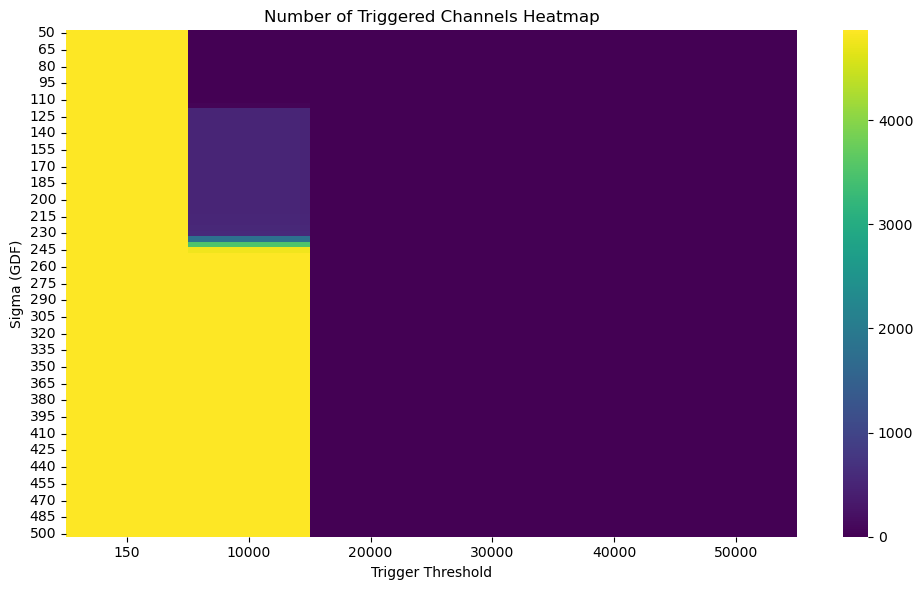

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import scipy.stats
from tqdm import tqdm
import multiprocessing as mp

# Load all traces
ka_data_1 = np.load('Ka_traces_1.npz')['data']
ka_data_2 = np.load('Ka_traces_2.npz')['data']
kb_data = np.load('Kb_traces.npz')['data']
traces = np.concatenate([ka_data_1, ka_data_2, kb_data], axis=0)


def get_gdf_kernel(sigma, n_sigma=3):
    x = np.arange(-sigma * n_sigma, sigma * n_sigma + 1)
    gaus = scipy.stats.norm(scale=sigma).pdf(x)
    kernel = np.diff(gaus)
    step_function = -np.heaviside(x[:-1], 1)
    return kernel / np.dot(kernel, step_function)


def threshold_trigger_2d(records, sigma, trigger_threshold=100, deactivation_threshold_coefficient=1, trigger_holdoff=0, n_sigma=3):
    kernel = get_gdf_kernel(sigma, n_sigma)
    num_records = len(records)
    triggered_channels = 0

    kernel_len = len(kernel)
    conv_len = records.shape[1] - kernel_len + 1

    for raw in records:
        filtered = signal.convolve(raw, kernel, mode='valid')
        deactivate_threshold = trigger_threshold * deactivation_threshold_coefficient
        hits = []
        triggered = False
        j = 0
        while j < conv_len:
            if not triggered and filtered[j] > trigger_threshold:
                hits.append(j)
                triggered = True
                j += trigger_holdoff
            elif triggered and filtered[j] < deactivate_threshold:
                triggered = False
            j += 1

        if len(hits) > 0:
            triggered_channels += 1

    metrics = {
        'triggered_channels': triggered_channels
    }
    return (sigma, trigger_threshold, metrics)


def evaluate_combo(args):
    return threshold_trigger_2d(traces, *args)


# --- Optimization & Evaluation Block (Multiprocessing) ---
sigmas = np.arange(50, 501, 5)
thresholds = np.array([150, 10000, 20000, 30000, 40000, 50000])

param_grid = [(sigma, threshold) for sigma in sigmas for threshold in thresholds]

with mp.Pool(processes=10) as pool:
    results = list(tqdm(pool.imap(evaluate_combo, param_grid), total=len(param_grid)))

# Organize results
results_df = pd.DataFrame([{
    'sigma': sigma,
    'threshold': threshold,
    'triggered_channels': metrics['triggered_channels']
} for sigma, threshold, metrics in results])

# Heatmap of triggered channels
pivot = results_df.pivot(index='sigma', columns='threshold', values='triggered_channels')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='viridis')
plt.title("Number of Triggered Channels Heatmap")
plt.xlabel("Trigger Threshold")
plt.ylabel("Sigma (GDF)")
plt.tight_layout()
plt.show()


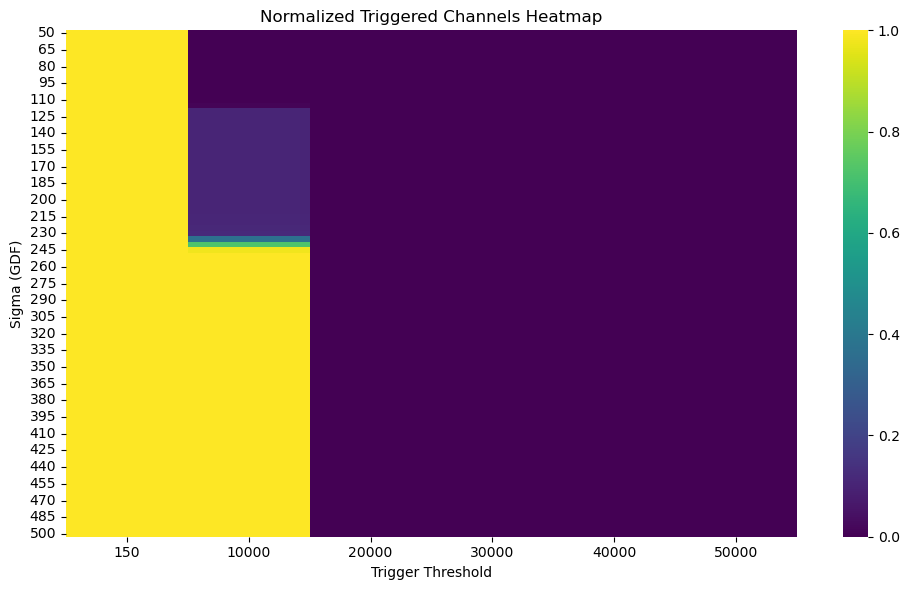

In [5]:
# Normalize triggered channel counts
total_traces = 4364 + 499  # 4863
pivot = results_df.pivot(index='sigma', columns='threshold', values='triggered_channels')
pivot_normalized = pivot / total_traces

# Plot normalized heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_normalized, cmap='viridis', vmin=0, vmax=1)
plt.title("Normalized Triggered Channels Heatmap")
plt.xlabel("Trigger Threshold")
plt.ylabel("Sigma (GDF)")
plt.tight_layout()
plt.show()
